In [9]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import joblib


from prophet import Prophet


df = pd.read_csv("../data/processed/climate_nasa_cleaned.csv", parse_dates=['date'])





In [10]:
import re

# Fill NaNs in text
df['text'] = df['text'].fillna("")

# Clean text
def clean_text_func(text):
    text = text.lower()                       # lowercase
    text = re.sub(r'http\S+', '', text)      # remove URLs
    text = re.sub(r'[^a-z\s]', '', text)     # remove punctuation/numbers
    text = text.strip()
    return text

df['clean_text'] = df['text'].apply(clean_text_func)

# Verify
df[['text','clean_text']].head()


,text,clean_text
0,Neat comparison I have not heard it before.\n ...,neat comparison i have not heard it before\n i...
1,An excellent way to visualise the invisible! T...,an excellent way to visualise the invisible th...
2,Does the CO2/ghg in the troposphere affect the...,does the coghg in the troposphere affect the s...
3,excellent post! I defo feel the difference - o...,excellent post i defo feel the difference one...
4,"Yes, and carbon dioxide does not harm the Eart...",yes and carbon dioxide does not harm the earth...


In [11]:
df['text_length'] = df['clean_text'].str.len()



In [12]:
from textblob import TextBlob

def get_sentiment(text):
    if not isinstance(text, str):
        text = ""
    polarity = TextBlob(text).sentiment.polarity
    if polarity > 0.1:
        return "positive"
    elif polarity < -0.1:
        return "negative"
    else:
        return "neutral"

df['sentiment'] = df['clean_text'].apply(get_sentiment)
df['sentiment'].value_counts()


sentiment
neutral     289
positive    150
negative     65
Name: count, dtype: int64

In [13]:
from sklearn.preprocessing import LabelEncoder

le_sentiment = LabelEncoder()
df['sentiment_encoded'] = le_sentiment.fit_transform(df['sentiment'])


In [14]:
features = ['sentiment_encoded', 'text_length']  # without topic


In [15]:
from sklearn.model_selection import train_test_split

X = df[['sentiment_encoded', 'text_length']]
y_likes = df['likesCount'].fillna(0)   # handle missing likes

X_train, X_test, y_train, y_test = train_test_split(X, y_likes, test_size=0.2, random_state=42)


In [16]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import numpy as np

regressor = RandomForestRegressor(n_estimators=100, random_state=42)
regressor.fit(X_train, y_train)

y_pred = regressor.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Likes Prediction RMSE: {rmse:.2f}")


Likes Prediction RMSE: 16.62


In [17]:
example = pd.DataFrame({
    'sentiment_encoded': [le_sentiment.transform(['positive'])[0]],
    'text_length': [120]
})

predicted_likes = regressor.predict(example)[0]
print(f"Predicted likes for example comment: {predicted_likes:.0f}")


Predicted likes for example comment: 3


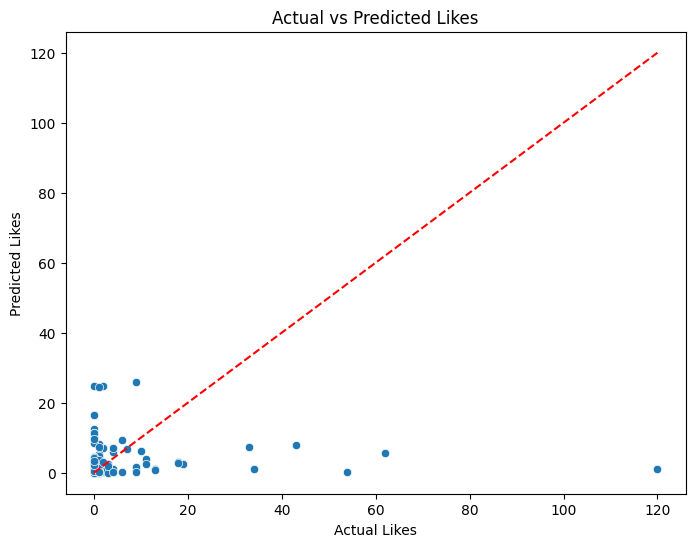

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,6))
sns.scatterplot(x=y_test, y=y_pred)
plt.xlabel("Actual Likes")
plt.ylabel("Predicted Likes")
plt.title("Actual vs Predicted Likes")
plt.plot([0, max(y_test)], [0, max(y_test)], color='red', linestyle='--')  # perfect prediction line
plt.show()


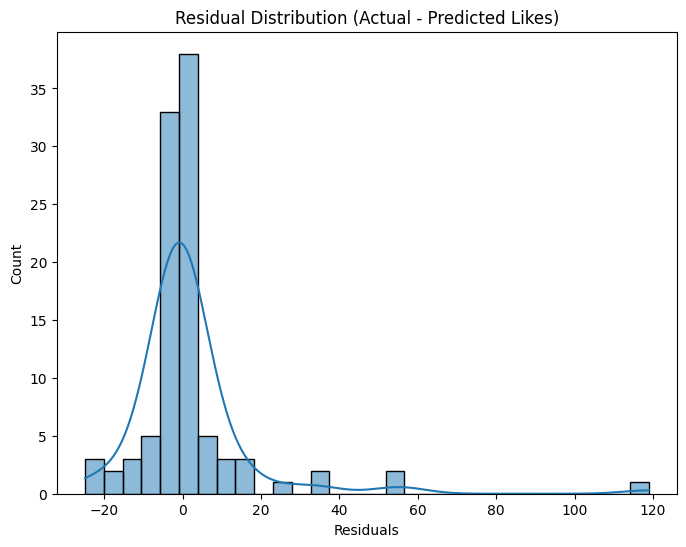

In [19]:
residuals = y_test - y_pred

plt.figure(figsize=(8,6))
sns.histplot(residuals, bins=30, kde=True)
plt.title("Residual Distribution (Actual - Predicted Likes)")
plt.xlabel("Residuals")
plt.show()


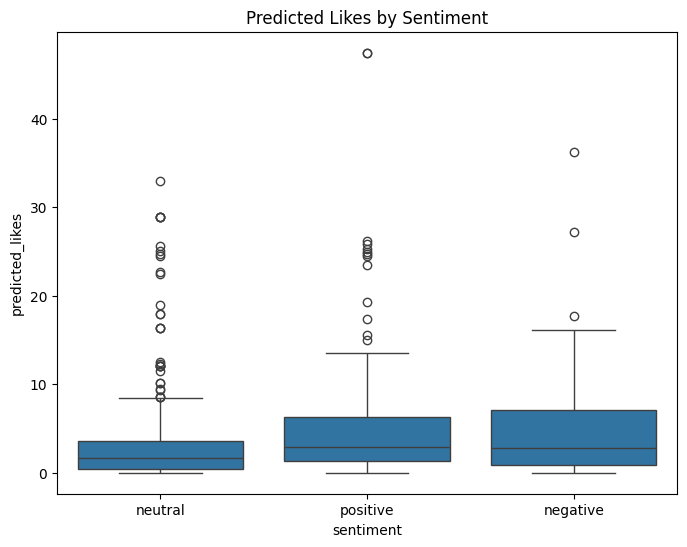

In [20]:
df['predicted_likes'] = regressor.predict(X)  # predict on full dataset

plt.figure(figsize=(8,6))
sns.boxplot(x='sentiment', y='predicted_likes', data=df)
plt.title("Predicted Likes by Sentiment")
plt.show()


In [21]:
top_comments = df[['text', 'predicted_likes']].sort_values(by='predicted_likes', ascending=False).head(10)
print(top_comments)


                                                  text  predicted_likes
452  So many Muppets trying to argue with scientist...        47.453821
121  I love watch NASA dunk on people who think the...        47.453821
433  To those who cite a very cold day as evidence ...        36.210000
484  Waiting for the science illiterates to come te...        32.950000
406  If it is a recurring cycle; why don’t we plan ...        28.897536
273  What's this, like the 19th hottest year on rec...        28.897536
310  It was "global warming" until science noticed ...        28.897536
416  I can only hope to someday attain the level of...        28.897536
403  Thanks for defining 'anomaly' in this context....        27.160000
425  The deniers don’t realize that it may be 20 de...        26.180000


             feature  importance
1        text_length    0.803311
0  sentiment_encoded    0.196689


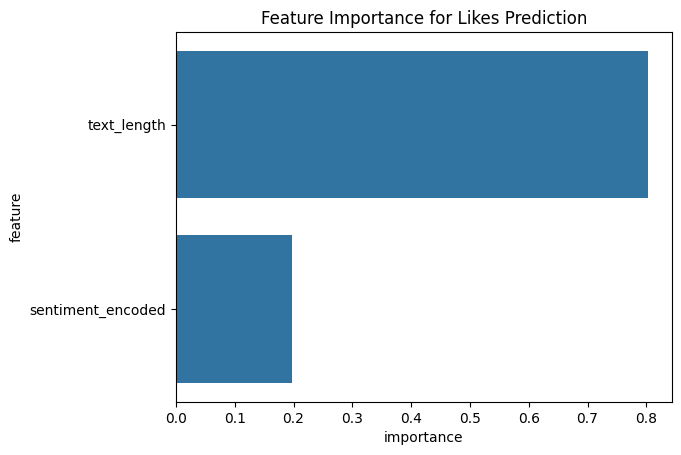

In [22]:
importances = regressor.feature_importances_
feature_names = X.columns

feat_imp = pd.DataFrame({'feature': feature_names, 'importance': importances}).sort_values(by='importance', ascending=False)
print(feat_imp)

sns.barplot(x='importance', y='feature', data=feat_imp)
plt.title("Feature Importance for Likes Prediction")
plt.show()
